# **🫁 Lung Cancer Image Classification - Preprocessing Pipeline**

## 📋 Project Overview
**Goal:** Build a deep learning model to classify lung CT scan images as **Normal** or **Malignant** (cancerous)

**This Notebook Covers:**
- ✅ Data loading and preprocessing
- ✅ Image enhancement using CLAHE
- ✅ Data augmentation strategies
- ✅ Dataset splitting (train/validation/test)
- ✅ Data visualization

---

## 🎯 Why Preprocessing Matters?
Medical images often have:
- Low contrast (hard to see differences)
- Varying sizes and orientations
- Different brightness levels

Proper preprocessing helps the model learn better patterns!

## 📦 Import Libraries

**What each library does:**

- **`torch`** - PyTorch deep learning framework
- **`torchvision`** - Image processing tools for PyTorch (datasets, transforms, models)
- **`cv2` (OpenCV)** - Computer vision library (we use it for CLAHE enhancement)
- **`PIL` (Python Imaging Library)** - Basic image loading and manipulation
- **`numpy`** - Numerical operations on arrays
- **`matplotlib/seaborn`** - Data visualization
- **`tqdm`** - Progress bars for loops (makes waiting less boring!)
- **`pandas`** - Data analysis (if needed)

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image

## ⚙️ Configuration Constants

**Why these specific values?**

- **`DATA_DIR`** - Path to your organized dataset folders (train/val/test)
  
- **`BATCH_SIZE = 32`** - Number of images processed together
  - **Why 32?** Good balance between:
    - **Memory usage** (32 images fit in most GPUs)
    - **Training speed** (processes 32 at once, faster than 1 at a time)
    - **Gradient stability** (averages over 32 samples reduces noise)
  - Common choices: 16, 32, 64, 128
  
- **`IMAGE_SIZE = 224`** - Standard input size for most pretrained models
  - **Why 224?** Most ImageNet pretrained models (ResNet, VGG, EfficientNet) expect 224×224 images
  - Using standard size lets us use transfer learning later!

In [2]:
# CONSTANTS

DATA_DIR = "F:/Machine Learning/PyTorch/Lung_Cancer/Final_Split_Data"
BATCH_SIZE = 32
IMAGE_SIZE = 224 # 224x224 image pixels


In [3]:
DATA_DIR

'F:/Machine Learning/PyTorch/Lung_Cancer/Final_Split_Data'

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# print(f"🖥️  Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
# print(f"⚡ CUDA Available: {torch.cuda.is_available()}")
# print(f"📊 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# # Test actual speed
# import time
# x = torch.randn(1000, 1000).cuda()
# start = time.time()
# y = x @ x
# torch.cuda.synchronize()
# print(f"⏱️  GPU Speed Test: {(time.time()-start)*1000:.2f}ms")

## 🔍 Custom CLAHE Transform

### What is CLAHE?
**CLAHE** = Contrast Limited Adaptive Histogram Equalization

### Why do we need it?
- Medical images (CT scans) often have **low contrast**
- Hard to see subtle differences between normal and cancerous tissue
- CLAHE **enhances local contrast** without over-amplifying noise

### How CLAHE works:
1. **Divides image into small tiles** (8×8 grid)
2. **Applies histogram equalization to each tile separately** (enhances local details)
3. **Limits contrast amplification** (`clip_limit=2.0` prevents noise explosion)
4. **Blends tile boundaries smoothly** (avoids checkerboard effect)

### Key Parameters:
- **`clip_limit=2.0`** - Controls maximum contrast enhancement
  - Lower = less enhancement (0.5-1.0 for subtle)
  - Higher = more enhancement (2.0-4.0 for aggressive)
  - We use 2.0 as a balanced middle ground
  
- **`tile_grid_size=(8, 8)`** - Divides image into 8×8 = 64 tiles
  - Smaller tiles (4×4) = more local enhancement
  - Larger tiles (16×16) = more global enhancement

### Why LAB Color Space for RGB images?
- LAB separates **luminance (L)** from **color (A, B)**
- We only enhance luminance channel → preserves original colors
- Converts: RGB → LAB → Enhance L → RGB

In [6]:
class ApplyCLAHE:
    def __init__(self, clip_limit=1, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img):

        # convert PIL image to numpy array
        img_np = np.array(img)

        # apply CLAHE
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

        # if gray scale
        if len(img_np.shape) == 2:
            img_clahe = clahe.apply(img_np)

        # if RGB, apply to each channel
        else:
            img_clahe = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            img_clahe[:, :, 0] = clahe.apply(img_clahe[:, :, 0])
            img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_LAB2RGB)
        
        return Image.fromarray(img_clahe)

## 🔄 Training Data Transforms (with Augmentation)

### Transform Pipeline Explained:

**1. `Grayscale(num_output_channels=1)`** - Convert to grayscale
   - **Why?** Lung CT scans don't need color, tissue structure matters more
   - Reduces data from 3 channels (RGB) to 1 channel

**2. `ApplyCLAHE(clip_limit=2.0)`** - Enhance contrast
   - Makes tissue differences more visible
   - Helps model detect subtle patterns

**3. `Grayscale(num_output_channels=3)`** - Convert back to 3-channel
   - **Why?** Pretrained models expect 3-channel input (RGB)
   - Simply triplicates the grayscale channel: [G] → [G, G, G]

**4. `Resize((234, 234))` + `RandomCrop((224, 224))`** - Augmentation!
   - Resize to slightly larger (234×234)
   - Then randomly crop to 224×224
   - **Why?** Each epoch sees different crops → model learns to be position-invariant
   - Prevents overfitting by adding variety

**5. `ToTensor()`** - Convert PIL Image → PyTorch Tensor
   - Changes range from [0, 255] → [0.0, 1.0]
   - Changes shape from (H, W, C) → (C, H, W)

**6. `Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])`**
   - **Why these numbers?** ImageNet statistics (standard for transfer learning)
   - Formula: `(pixel - mean) / std`
   - Centers data around 0, makes training more stable
   - Required if using pretrained models!

In [7]:
# tranformers (grayscale, resize, to tensor, normalize)

train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE + 10, IMAGE_SIZE + 10)),
    transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## ✅ Validation/Test Transforms (Deterministic)

### Key Difference from Training Transforms:

**NO Random Augmentation!**
- **Training:** Uses `RandomCrop` → different crops each time
- **Val/Test:** Direct `Resize` → same image every time

### Why No Augmentation for Val/Test?
- **Consistency:** We want to evaluate model performance on same images
- **Fair comparison:** Results should be reproducible
- **Real-world simulation:** During deployment, you'll use raw images

### Transform Pipeline:
1. **Grayscale** → CLAHE enhancement → **3-channel**
2. **Direct resize to 224×224** (no random crop)
3. **ToTensor** + **Normalize** (same as training)

This ensures val/test preprocessing matches training preprocessing exactly, except for randomness!

In [8]:
# Val/Test transforms (deterministic)
val_test_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    ApplyCLAHE(clip_limit=2.0, tile_grid_size=(8, 8)),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Direct resize, no crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

## 📂 Load Datasets

### What is `ImageFolder`?
PyTorch's convenient dataset loader that expects this structure:
```
Final_Split_Data/
├── train/
│   ├── Malignant/   (all cancer images here)
│   └── Normal/      (all normal images here)
├── val/
│   ├── Malignant/
│   └── Normal/
└── test/
    ├── Malignant/
    └── Normal/
```

### How it Works:
- **Automatically assigns labels** based on folder names
  - Malignant = class 0 or 1
  - Normal = class 0 or 1
- **Applies transforms** to each image when loading
- **Returns:** (image_tensor, label) pairs

### Why Separate Datasets?
- **Training set:** Used to learn patterns (largest split, ~70-80%)
- **Validation set:** Tune hyperparameters, check overfitting (~10-15%)
- **Test set:** Final evaluation, never seen during training (~10-15%)

In [9]:
# laod dataset

train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=val_test_transforms)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=val_test_transforms)

## 🔄 Create DataLoaders

### What is a DataLoader?
A DataLoader wraps a dataset and provides:
- **Batching:** Groups images into batches
- **Shuffling:** Randomizes order (for training only)
- **Parallel loading:** Loads data in background while model trains
- **Memory management:** Efficient data transfer to GPU

### Parameter Explanations:

**`batch_size=32`**
- Processes 32 images at once
- GPU computes gradients for all 32, then averages them

**`shuffle=True` (training only)**
- **Training:** `shuffle=True` → random order each epoch (prevents learning order patterns)
- **Val/Test:** `shuffle=False` → same order (consistency)

**`num_workers=2`**
- Uses 2 CPU threads to load data in background
- **Why 2?** Good balance for most systems
  - 0 = single-threaded (slow, blocks training)
  - 2-4 = parallel loading (faster, keeps GPU busy)
  - Too many = memory overhead

**`pin_memory=False`**
- `True` = faster GPU transfer (but uses more RAM)
- `False` = slower transfer (but safer for limited RAM)

**`persistent_workers=True`**
- Keeps workers alive between epochs
- **Benefit:** Faster epoch transitions (no worker restart overhead)
- **Cost:** Uses more memory

### Output Explanation:
- **Dataset sizes:** Total number of images
- **Loader sizes:** Number of batches (images ÷ batch_size)

In [ ]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=3, 
    pin_memory=True, 
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3,
    pin_memory=True,
    persistent_workers=True
)

print(f"✅ Data loaded successfully!")
print("✅ Classes : ", train_dataset.classes)
print("✅ Dataset sizes : Train", len(train_dataset))
print("✅ Dataset sizes : Validation", len(val_dataset))
print("✅ Dataset sizes : Test", len(test_dataset))

✅ Data loaded successfully!
✅ Classes :  ['Malignant', 'Normal']
✅ Dataset sizes : Train 3408
✅ Dataset sizes : Validation 426
✅ Dataset sizes : Test 428


In [11]:
print(len(train_loader), len(val_loader), len(test_loader))

107 14 14


## 🛠️ Error Handling for Corrupted Images

### What does this do?
**`LOAD_TRUNCATED_IMAGES = True`** allows PIL to load partially corrupted images

### Why needed?
- Sometimes image files get corrupted during download/transfer
- Without this, training crashes with "image file truncated" error
- With this, PIL attempts to load as much as possible

### When to use:
- Large datasets downloaded from internet
- Medical imaging datasets (often have file issues)
- Any dataset where you can't manually verify every image

In [12]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## 📊 Visualize Class Distribution

### Why check class distribution?

**Class Imbalance Problem:**
- If dataset has 900 Normal and 100 Malignant images
- Model might just predict "Normal" for everything → 90% accuracy!
- But it never learned to detect cancer (terrible for medical use)

### What to look for:
- ✅ **Balanced:** Both classes have similar counts (~50/50)
- ⚠️ **Slightly imbalanced:** 60/40 or 70/30 (often okay)
- ❌ **Severely imbalanced:** 90/10 or worse (needs special handling)

### If imbalanced, solutions:
1. **Data augmentation** (generate more samples for minority class) ← I did this offline!
2. **Class weights** (penalize model more for minority class errors)
3. **Oversampling/Undersampling**
4. **Use F1-score instead of accuracy**

### This Plot Shows:
- Red bar = Malignant images count
- Green bar = Normal images count
- Ideally should be roughly equal!

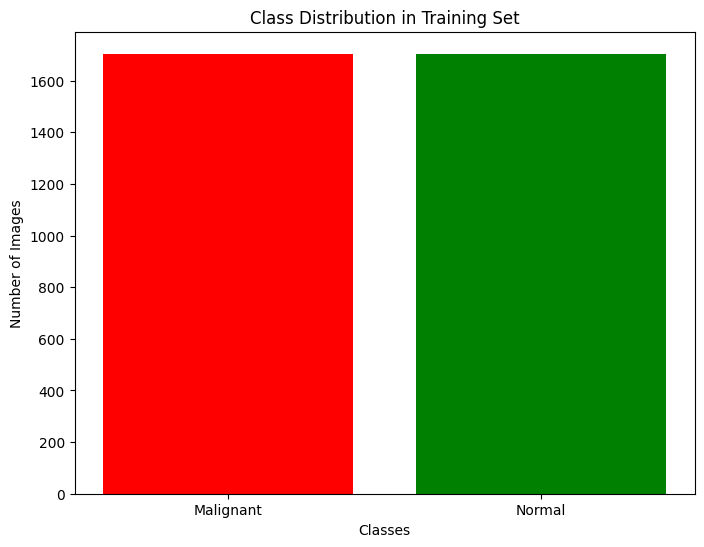

In [13]:
from collections import Counter
import matplotlib.pyplot as plt

labels = train_dataset.targets
label_counts = Counter(labels)

class_names = train_dataset.classes
class_labels = [class_names[i] for i in label_counts.keys()]
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_labels, counts, color=['red', 'green'])
plt.title("Class Distribution in Training Set")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()

## 🖼️ Visualize Sample Images

### Why visualize?

**Quality Control:**
1. ✅ **Verify transforms work:** Are images properly enhanced?
2. ✅ **Check labels:** Do labels match images?
3. ✅ **Spot errors:** Are there any corrupted/wrong images?
4. ✅ **Understand data:** What does the model actually see?

### Function Breakdown:

**`show_batch()` function:**
- **Randomly samples** images from dataset
- **Unnormalizes** them (reverses normalization to display properly)
- **Displays in grid** (3 rows × 5 cols = 15 images)

### Why Unnormalize?
- Training images are normalized: `(pixel - 0.485) / 0.229`
- This makes pixel values negative/strange
- To display properly: `pixel = normalized * 0.229 + 0.485`
- Then clamp to [0, 1] range

### What to Check:
- ✅ CLAHE enhancement working? (good contrast)
- ✅ Images clearly visible?
- ✅ Labels match image content?
- ✅ Any obvious corrupted images?

**Pro Tip:** Run this multiple times to see different random samples!

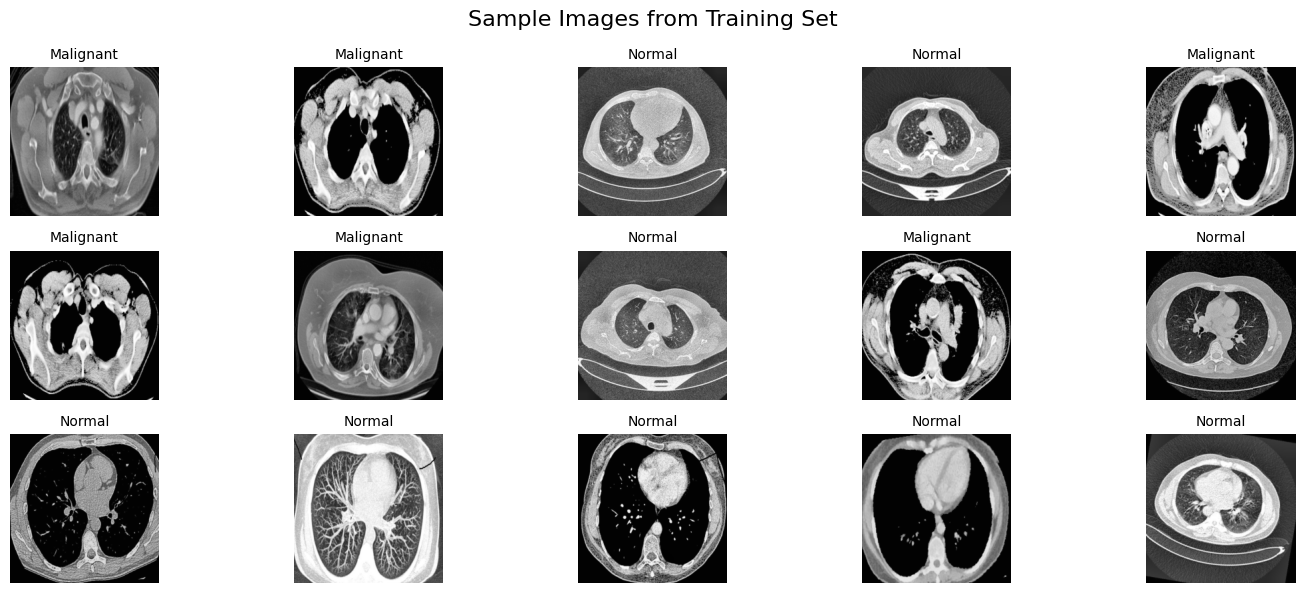

In [14]:
def show_batch(dataset, class_names, num_images=24):
    
    # Get images directly from dataset (much faster)
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)
    
    rows = 3
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))

    # Unnormalize parameters
    mean = torch.tensor([0.485, 0.485, 0.485]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.229, 0.229]).view(3, 1, 1)

    for i, ax in enumerate(axes.flatten()):
        if i < len(indices):
            img, label = dataset[indices[i]]
            
            # Unnormalize
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            
            # Convert to numpy
            img = img.numpy().transpose((1, 2, 0))
            
            ax.imshow(img, cmap='gray')
            ax.set_title(class_names[label], fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.suptitle("Sample Images from Training Set", fontsize=16)
    plt.tight_layout()
    plt.show()

# Call with dataset instead of dataloader
show_batch(train_dataset, train_dataset.classes)

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

#         Architecture:
# - Conv2D(32) → ReLU → MaxPool → Dropout(0.25)
# - Conv2D(64) → ReLU → MaxPool → Dropout(0.25)
# - Conv2D(128) → ReLU → MaxPool → Dropout(0.3)
# - Flatten
# - Dense(512) → ReLU → Dropout(0.5)
# - Dense(2) → Softmax

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjusted for 224x224 input size

        self.fc2 = nn.Linear(512, 2)  # 2 output classes

        self.dropout25 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout5 = nn.Dropout(0.5)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout25(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout25(x)

        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout3(x)

        x = x.view(-1, 128 * 28 * 28)  # Flatten

        x = F.relu(self.fc1(x))
        x = self.dropout5(x)

        x = self.fc2(x)
        return x


In [17]:
model = SimpleCNN()

print(model)

dummy_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE)
output = model(dummy_input)
print("✅ Model forward pass successful! Output shape:", output.shape)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Total parameters: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (dropout5): Dropout(p=0.5, inplace=False)
)
✅ Model forward pass successful! Output shape: torch.Size([1, 2])
✅ Total parameters: 51475010


In [ ]:
print("⏳ Loading first batch (workers initializing, ~10-20 seconds)...")
images, labels = next(iter(train_loader))
print("✅ Workers ready! Future batches will be fast.")
print("Input batch shape:", images.shape)

⏳ Loading first batch (workers initializing, ~10-20 seconds)...


In [ ]:
# test with real batch from dataloader

print("Testing model with real batch from dataloader...")

# Get a batch from the train_loader
images, labels = next(iter(train_loader))
print("Input batch shape:", images.shape)
print("Labels shape:", labels.shape)

model.eval()
with torch.no_grad():
    outputs = model(images)

print("Output batch shape:", outputs.shape)
print("✅ Model forward pass with real batch successful!")

In [ ]:
# Get probabilities (apply softmax)
probabilities = F.softmax(outputs, dim=1)
print(f"✅ Probabilities shape: {probabilities.shape}")
print(f"✅ First 5 predictions:")
print(probabilities[:5])

# Get predicted classes
predicted_classes = torch.argmax(probabilities, dim=1)
print(f"✅ Predicted classes: {predicted_classes[:10]}")
print(f"✅ True labels: {labels[:10]}")

In [ ]:
# overfitting test

print("🧪 Overfitting test (can model memorize 1 batch?)...\n")

test_model = SimpleCNN()
test_model.train()

# Get a single batch
images, labels = next(iter(train_loader))

# simple training loop 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(50):  # 50 epochs
    optimizer.zero_grad()
    
    outputs = test_model(images)
    loss = criterion(outputs, labels)
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        # Check accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).sum().item() / len(labels)
        print(f"Epoch {epoch+1}: Loss={loss.item():.4f}, Acc={accuracy:.2%}")
    
print("\n✅ Overfitting test completed.")

In [ ]:
# Install torchinfo if needed: pip install torchinfo
from torchinfo import summary

# Detailed model summary
print(summary(model, input_size=(1, 3, 224, 224), 
              col_names=["input_size", "output_size", "num_params"]))